# TP : Comparaison des Solveurs dans la Régression Logistique avec scikit-learn

## 1. Implémentation Complète du Notebook

# %% [markdown]
# # TP : Impact des Solveurs dans la Régression Logistique
# 
# **Objectif** : Comparer l'impact des différents solveurs d'optimisation sur la performance
# et le comportement de la régression logistique avec scikit-learn.
# 
# ## Étapes :
# 1. Chargement et préparation des données
# 2. Implémentation avec différents solveurs
# 3. Comparaison des performances
# 4. Analyse des résultats

# %% [markdown]

### 1. Importation des bibliothèques

In [ ]:

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_curve, auc,
                           classification_report, log_loss)
from sklearn.datasets import make_classification, load_breast_cancer, load_iris
import time
import warnings
warnings.filterwarnings('ignore')

# %%
# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

# %% [markdown]

In [2]:


# ## 2. Génération/Création des données

# %%
# Option 1 : Données synthétiques (pour un contrôle total)
print("Création de données synthétiques...")
X_synth, y_synth = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42,
    class_sep=0.8  # Séparabilité des classes
)

# Option 2 : Dataset réel (Breast Cancer)
print("\nChargement du dataset Breast Cancer...")
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target

# Option 3 : Dataset Iris (pour classification multiclasse)
print("Chargement du dataset Iris...")
iris = load_iris()
# On ne garde que 2 classes pour la classification binaire
X_iris = iris.data[iris.target != 2]
y_iris = iris.target[iris.target != 2]

print(f"\nDimensions des datasets:")
print(f"- Synthétique: {X_synth.shape}")
print(f"- Cancer: {X_cancer.shape}")
print(f"- Iris: {X_iris.shape}")

# %% [markdown]


Création de données synthétiques...

Chargement du dataset Breast Cancer...
Chargement du dataset Iris...

Dimensions des datasets:
- Synthétique: (1000, 20)
- Cancer: (569, 30)
- Iris: (100, 4)


In [3]:
# ## 3. Préparation des données

# %%
def prepare_data(X, y, test_size=0.3, random_state=42):
    """Prépare les données pour l'entraînement"""
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Standardisation (important pour certains solveurs)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Préparation des 3 datasets
print("Préparation des données...")
X_synth_train, X_synth_test, y_synth_train, y_synth_test, _ = prepare_data(X_synth, y_synth)
X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test, _ = prepare_data(X_cancer, y_cancer)
X_iris_train, X_iris_test, y_iris_train, y_iris_test, _ = prepare_data(X_iris, y_iris)

print("Données préparées avec succès!")

# %% [markdown]

Préparation des données...
Données préparées avec succès!


In [5]:
# ## 4. Liste des solveurs à comparer

# %%
# Solveurs disponibles dans scikit-learn avec leurs caractéristiques
solvers_info = {
    'lbfgs': {
        'description': 'L-BFGS (Limited-memory BFGS) - Méthode quasi-Newton',
        'penalties': ['l2', None],
        'supports_multiclass': True,
        'good_for': 'petits à moyens datasets'
    },
    'liblinear': {
        'description': 'Bibliothèque LIBLINEAR - Méthode de coordinate descent',
        'penalties': ['l1', 'l2'],
        'supports_multiclass': False,  # Uniquement binaire en one-vs-rest
        'good_for': 'petits datasets'
    },
    'newton-cg': {
        'description': 'Méthode de Newton avec gradient conjugué',
        'penalties': ['l2', None],
        'supports_multiclass': True,
        'good_for': 'datasets avec nombreuses features'
    },
    'sag': {
        'description': 'Stochastic Average Gradient',
        'penalties': ['l2', None],
        'supports_multiclass': True,
        'good_for': 'grands datasets'
    },
    'saga': {
        'description': 'Amélioration de SAG supportant L1',
        'penalties': ['l1', 'l2', 'elasticnet', None],
        'supports_multiclass': True,
        'good_for': 'très grands datasets avec régularisation L1'
    }
}

print("Solveurs à comparer:")
for solver, info in solvers_info.items():
    print(f"\n{solver.upper()}:")
    print(f"  Description: {info['description']}")
    print(f"  Pénalités supportées: {info['penalties']}")
    print(f"  Multiclasse: {info['supports_multiclass']}")
    print(f"  Recommandé pour: {info['good_for']}")

# %% [markdown]

Solveurs à comparer:

LBFGS:
  Description: L-BFGS (Limited-memory BFGS) - Méthode quasi-Newton
  Pénalités supportées: ['l2', None]
  Multiclasse: True
  Recommandé pour: petits à moyens datasets

LIBLINEAR:
  Description: Bibliothèque LIBLINEAR - Méthode de coordinate descent
  Pénalités supportées: ['l1', 'l2']
  Multiclasse: False
  Recommandé pour: petits datasets

NEWTON-CG:
  Description: Méthode de Newton avec gradient conjugué
  Pénalités supportées: ['l2', None]
  Multiclasse: True
  Recommandé pour: datasets avec nombreuses features

SAG:
  Description: Stochastic Average Gradient
  Pénalités supportées: ['l2', None]
  Multiclasse: True
  Recommandé pour: grands datasets

SAGA:
  Description: Amélioration de SAG supportant L1
  Pénalités supportées: ['l1', 'l2', 'elasticnet', None]
  Multiclasse: True
  Recommandé pour: très grands datasets avec régularisation L1


In [6]:
# ## 5. Fonction d'évaluation complète

# %%
def evaluate_solver(X_train, X_test, y_train, y_test, solver, penalty='l2', 
                   dataset_name="Dataset", C=1.0, max_iter=1000):
    """
    Évalue un solveur spécifique sur un dataset
    """
    results = {}
    
    # Vérification de la compatibilité solveur/pénalité
    if penalty not in solvers_info[solver]['penalties']:
        print(f"⚠️  Attention: {solver} ne supporte pas la pénalité {penalty}")
        return None
    
    try:
        start_time = time.time()
        
        # Création et entraînement du modèle
        model = LogisticRegression(
            solver=solver,
            penalty=penalty,
            C=C,
            max_iter=max_iter,
            random_state=42,
            n_jobs=-1  # Utilisation de tous les cœurs
        )
        
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Prédictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) == 2 else None
        
        # Métriques de performance
        results['accuracy'] = accuracy_score(y_test, y_pred)
        results['precision'] = precision_score(y_test, y_pred, average='weighted')
        results['recall'] = recall_score(y_test, y_pred, average='weighted')
        results['f1'] = f1_score(y_test, y_pred, average='weighted')
        
        # Log loss (si binaire)
        if y_pred_proba is not None:
            results['log_loss'] = log_loss(y_test, y_pred_proba)
        
        # Informations sur le modèle
        results['training_time'] = training_time
        results['n_iter'] = model.n_iter_[0] if hasattr(model.n_iter_, '__len__') else model.n_iter_
        results['converged'] = model.n_iter_ < max_iter
        results['coef_norm'] = np.linalg.norm(model.coef_) if hasattr(model, 'coef_') else None
        
        # Nombre de features sélectionnées (pour L1)
        if penalty == 'l1' and hasattr(model, 'coef_'):
            results['n_selected_features'] = np.sum(model.coef_[0] != 0)
        
        print(f"✅ {solver} évalué sur {dataset_name}")
        
    except Exception as e:
        print(f"❌ Erreur avec {solver} sur {dataset_name}: {str(e)}")
        return None
    
    return results

# %% [markdown]

In [7]:
# ## 6. Comparaison systématique sur le dataset synthétique

# %%
print("=" * 70)
print("COMPARAISON DES SOLVEURS SUR DATASET SYNTHÉTIQUE")
print("=" * 70)

# Dictionnaire pour stocker les résultats
results_synth = {}

for solver in solvers_info.keys():
    print(f"\n{'='*50}")
    print(f"Testing {solver.upper()}...")
    
    # Test avec pénalité L2 (supportée par tous les solveurs testés)
    results = evaluate_solver(
        X_synth_train, X_synth_test, y_synth_train, y_synth_test,
        solver=solver, penalty='l2', dataset_name="Synthétique"
    )
    
    if results:
        results_synth[solver] = results
        
        # Affichage rapide des résultats
        print(f"  Accuracy: {results['accuracy']:.4f}")
        print(f"  Temps d'entraînement: {results['training_time']:.4f}s")
        print(f"  Nombre d'itérations: {results['n_iter']}")
        print(f"  Convergé: {results['converged']}")

# %% [markdown]

COMPARAISON DES SOLVEURS SUR DATASET SYNTHÉTIQUE

Testing LBFGS...
✅ lbfgs évalué sur Synthétique
  Accuracy: 0.7500
  Temps d'entraînement: 2.1300s
  Nombre d'itérations: 12
  Convergé: [ True]

Testing LIBLINEAR...
✅ liblinear évalué sur Synthétique
  Accuracy: 0.7500
  Temps d'entraînement: 0.0055s
  Nombre d'itérations: 5
  Convergé: [ True]

Testing NEWTON-CG...
✅ newton-cg évalué sur Synthétique
  Accuracy: 0.7500
  Temps d'entraînement: 1.7332s
  Nombre d'itérations: 5
  Convergé: [ True]

Testing SAG...
✅ sag évalué sur Synthétique
  Accuracy: 0.7500
  Temps d'entraînement: 0.0630s
  Nombre d'itérations: 34
  Convergé: [ True]

Testing SAGA...
✅ saga évalué sur Synthétique
  Accuracy: 0.7500
  Temps d'entraînement: 0.0294s
  Nombre d'itérations: 16
  Convergé: [ True]



Visualisation des résultats pour le dataset synthétique...


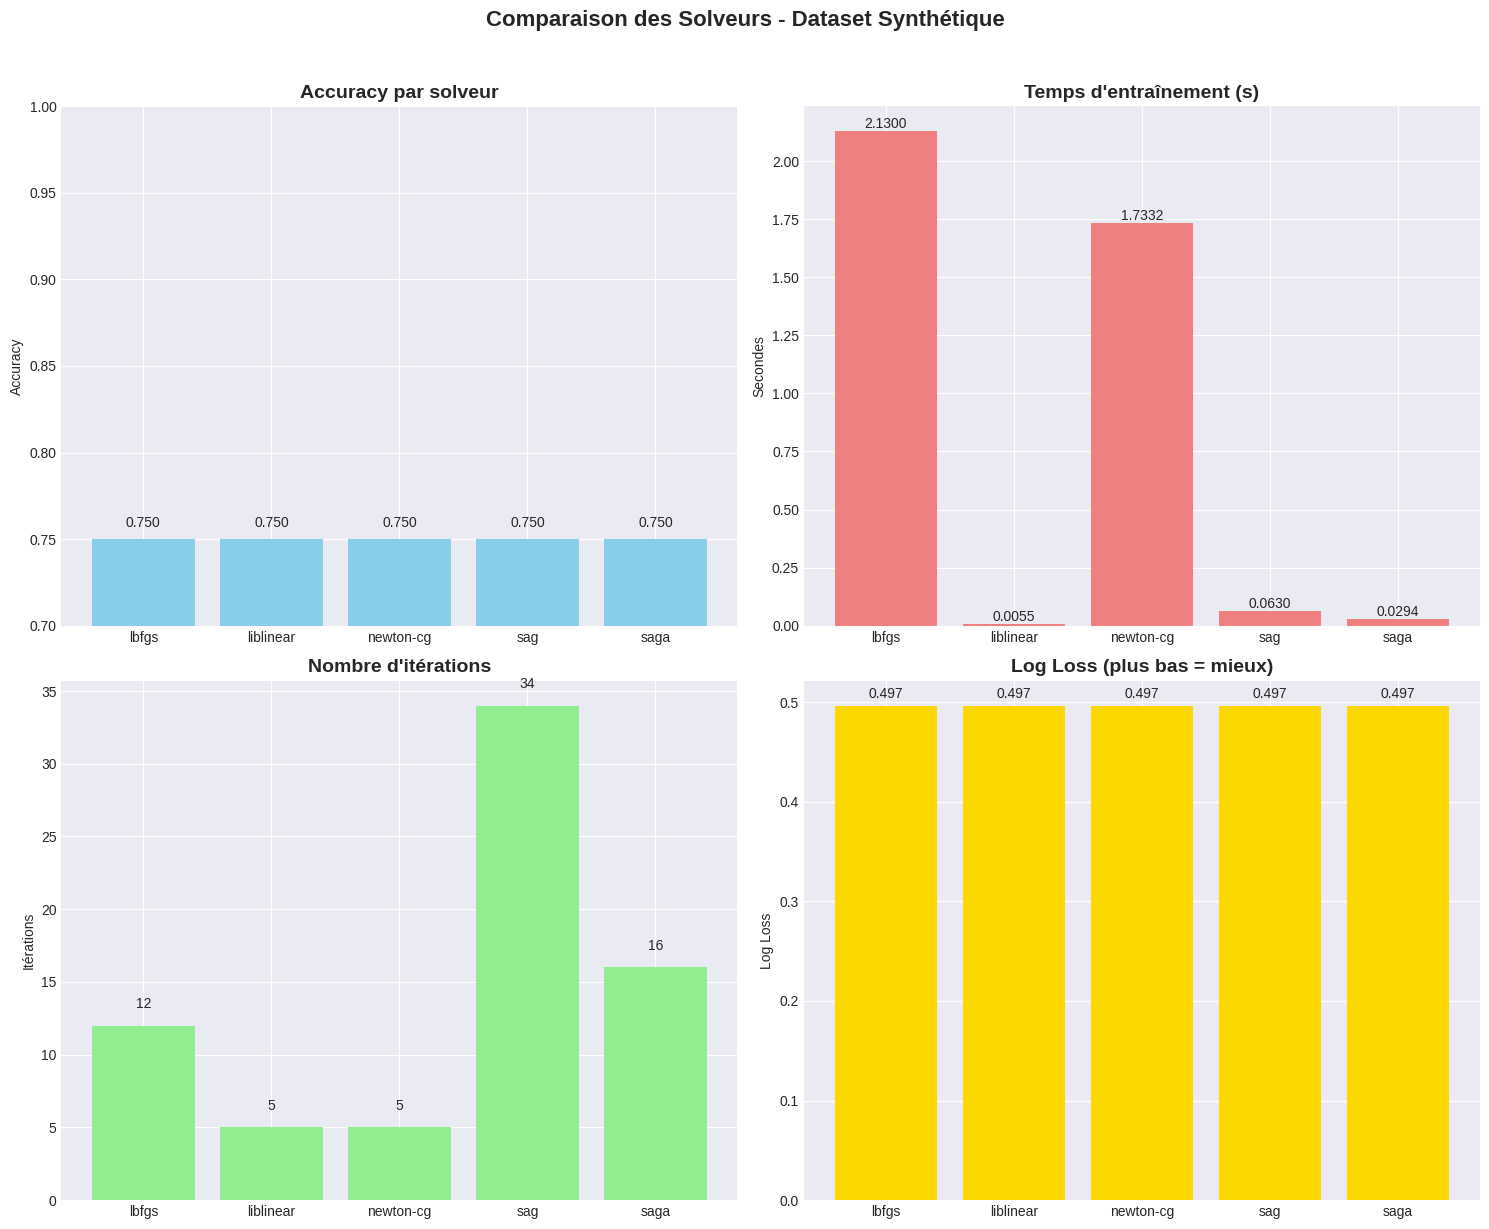

In [8]:
# ## 7. Visualisation des résultats

# %%
def plot_comparison(results_dict, title="Comparaison des Solveurs"):
    """Visualise la comparaison des solveurs"""
    
    if not results_dict:
        print("Aucun résultat à visualiser")
        return
    
    solvers = list(results_dict.keys())
    metrics = ['accuracy', 'training_time', 'n_iter', 'log_loss']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    # Accuracy
    accuracies = [results_dict[s].get('accuracy', 0) for s in solvers]
    bars1 = axes[0].bar(solvers, accuracies, color='skyblue')
    axes[0].set_title('Accuracy par solveur', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim([min(accuracies) - 0.05, 1.0])
    # Ajout des valeurs sur les barres
    for bar, acc in zip(bars1, accuracies):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{acc:.3f}', ha='center', va='bottom')
    
    # Temps d'entraînement
    times = [results_dict[s].get('training_time', 0) for s in solvers]
    bars2 = axes[1].bar(solvers, times, color='lightcoral')
    axes[1].set_title('Temps d\'entraînement (s)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Secondes')
    # Ajout des valeurs
    for bar, t in zip(bars2, times):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0005,
                    f'{t:.4f}', ha='center', va='bottom')
    
    # Nombre d'itérations
    iterations = [results_dict[s].get('n_iter', 0) for s in solvers]
    bars3 = axes[2].bar(solvers, iterations, color='lightgreen')
    axes[2].set_title('Nombre d\'itérations', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Itérations')
    # Ajout des valeurs
    for bar, it in zip(bars3, iterations):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{it}', ha='center', va='bottom')
    
    # Log Loss (si disponible)
    losses = [results_dict[s].get('log_loss', np.nan) for s in solvers]
    valid_losses = [(i, loss) for i, loss in enumerate(losses) if not np.isnan(loss)]
    if valid_losses:
        indices, valid_vals = zip(*valid_losses)
        valid_solvers = [solvers[i] for i in indices]
        bars4 = axes[3].bar(valid_solvers, valid_vals, color='gold')
        axes[3].set_title('Log Loss (plus bas = mieux)', fontsize=14, fontweight='bold')
        axes[3].set_ylabel('Log Loss')
        # Ajout des valeurs
        for bar, loss in zip(bars4, valid_vals):
            axes[3].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{loss:.3f}', ha='center', va='bottom')
    else:
        axes[3].text(0.5, 0.5, 'Log Loss non disponible\n(pour classification binaire uniquement)',
                    ha='center', va='center', fontsize=12)
        axes[3].set_title('Log Loss', fontsize=14, fontweight='bold')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Visualisation pour le dataset synthétique
print("\nVisualisation des résultats pour le dataset synthétique...")
plot_comparison(results_synth, "Comparaison des Solveurs - Dataset Synthétique")


In [9]:
# %% [markdown]
# ## 8. Comparaison approfondie avec différentes pénalités

# %%
print("=" * 70)
print("COMPARAISON AVEC DIFFÉRENTES PÉNALITÉS (L1 vs L2)")
print("=" * 70)

# Test spécifique avec L1 et L2 sur les solveurs qui les supportent
l1_l2_comparison = {}

test_solvers = ['liblinear', 'saga']  # Ceux qui supportent L1 et L2

for solver in test_solvers:
    for penalty in ['l1', 'l2']:
        key = f"{solver}_{penalty}"
        print(f"\nTesting {key}...")
        
        results = evaluate_solver(
            X_synth_train, X_synth_test, y_synth_train, y_synth_test,
            solver=solver, penalty=penalty, dataset_name="Synthétique"
        )
        
        if results:
            l1_l2_comparison[key] = results
            print(f"  Accuracy: {results['accuracy']:.4f}")
            if penalty == 'l1':
                print(f"  Features sélectionnées: {results.get('n_selected_features', 'N/A')}")

# %% [markdown]

COMPARAISON AVEC DIFFÉRENTES PÉNALITÉS (L1 vs L2)

Testing liblinear_l1...
✅ liblinear évalué sur Synthétique
  Accuracy: 0.7500
  Features sélectionnées: 15

Testing liblinear_l2...
✅ liblinear évalué sur Synthétique
  Accuracy: 0.7500

Testing saga_l1...
✅ saga évalué sur Synthétique
  Accuracy: 0.7500
  Features sélectionnées: 15

Testing saga_l2...
✅ saga évalué sur Synthétique
  Accuracy: 0.7500


ANALYSE DE CONVERGENCE DES SOLVEURS

Analyse de convergence pour lbfgs:
  max_iter=50: accuracy=0.7500, time=0.050s, converged=True
  max_iter=100: accuracy=0.7500, time=0.010s, converged=True
  max_iter=200: accuracy=0.7500, time=0.006s, converged=True
  max_iter=500: accuracy=0.7500, time=0.006s, converged=True
  max_iter=1000: accuracy=0.7500, time=0.006s, converged=True

Analyse de convergence pour liblinear:
  max_iter=50: accuracy=0.7500, time=0.004s, converged=True
  max_iter=100: accuracy=0.7500, time=0.004s, converged=True
  max_iter=200: accuracy=0.7500, time=0.004s, converged=True
  max_iter=500: accuracy=0.7500, time=0.004s, converged=True
  max_iter=1000: accuracy=0.7500, time=0.005s, converged=True

Analyse de convergence pour saga:
  max_iter=50: accuracy=0.7500, time=0.011s, converged=True
  max_iter=100: accuracy=0.7500, time=0.011s, converged=True
  max_iter=200: accuracy=0.7500, time=0.012s, converged=True
  max_iter=500: accuracy=0.7500, time=0.013s, converged=True


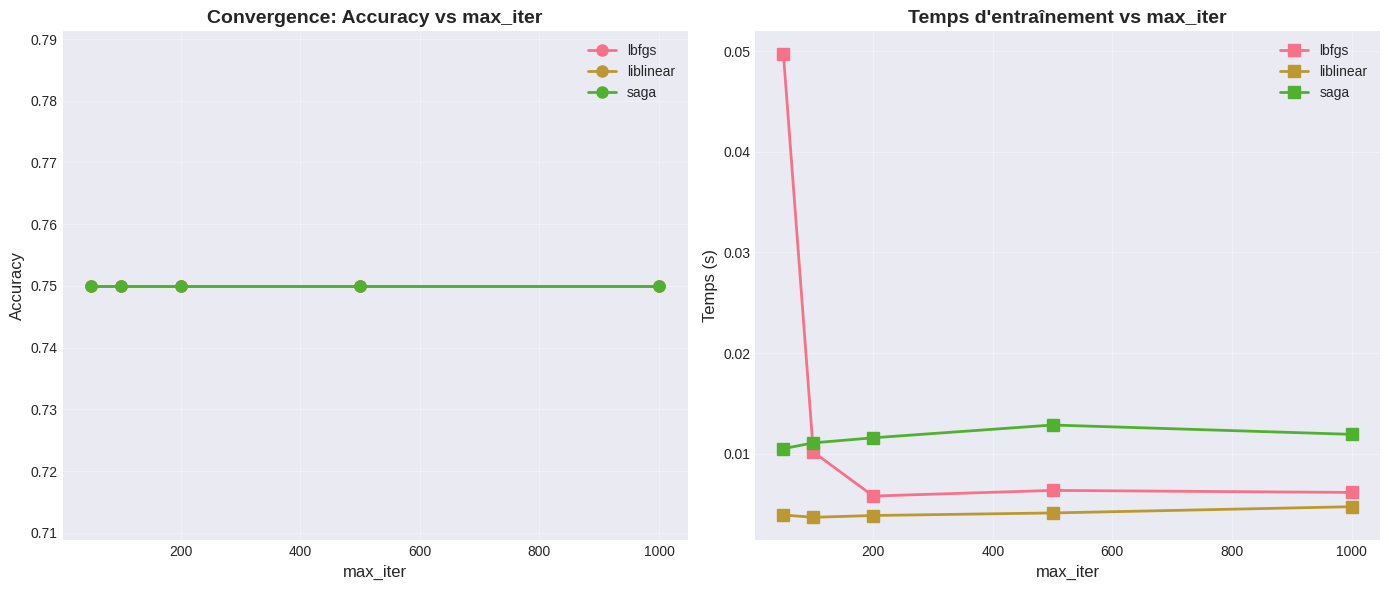

In [12]:

# ## 9. Analyse de convergence

# %%
print("=" * 70)
print("ANALYSE DE CONVERGENCE DES SOLVEURS")
print("=" * 70)

# Test avec différentes valeurs de max_iter pour analyser la convergence
def analyze_convergence(solver, max_iters=[50, 100, 200, 500, 1000]):
    """Analyse la convergence d'un solveur avec différents max_iter"""
    
    accuracies = []
    times = []
    
    print(f"\nAnalyse de convergence pour {solver}:")
    for max_iter in max_iters:
        try:
            start_time = time.time()
            
            model = LogisticRegression(
                solver=solver,
                max_iter=max_iter,
                random_state=42,
                C=1.0,
                penalty='l2'
            )
            
            model.fit(X_synth_train, y_synth_train)
            training_time = time.time() - start_time
            
            y_pred = model.predict(X_synth_test)
            accuracy = accuracy_score(y_synth_test, y_pred)
            
            accuracies.append(accuracy)
            times.append(training_time)
            
            converged = model.n_iter_[0] < max_iter if hasattr(model.n_iter_, '__len__') else model.n_iter_ < max_iter
            
            print(f"  max_iter={max_iter}: accuracy={accuracy:.4f}, "
                  f"time={training_time:.3f}s, converged={converged}")
            
        except Exception as e:
            print(f"  max_iter={max_iter}: Erreur - {str(e)}")
            accuracies.append(np.nan)
            times.append(np.nan)
    
    return max_iters, accuracies, times

# Analyse pour quelques solveurs représentatifs
solvers_to_analyze = ['lbfgs', 'liblinear', 'saga']
convergence_data = {}

for solver in solvers_to_analyze:
    iters, accs, times = analyze_convergence(solver)
    convergence_data[solver] = {'iterations': iters, 'accuracies': accs, 'times': times}

# Visualisation de la convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for solver in convergence_data:
    data = convergence_data[solver]
    ax1.plot(data['iterations'], data['accuracies'], 'o-', linewidth=2, markersize=8, label=solver)
    ax2.plot(data['iterations'], data['times'], 's-', linewidth=2, markersize=8, label=solver)

ax1.set_xlabel('max_iter', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Convergence: Accuracy vs max_iter', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('max_iter', fontsize=12)
ax2.set_ylabel('Temps (s)', fontsize=12)
ax2.set_title('Temps d\'entraînement vs max_iter', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]

IMPACT DU PARAMÈTRE DE RÉGULARISATION C

Impact de C pour lbfgs:
  C=0.001: Erreur - Invalid format specifier
  C=0.010: Erreur - Invalid format specifier
  C=0.100: Erreur - Invalid format specifier
  C=1.000: Erreur - Invalid format specifier
  C=10.000: Erreur - Invalid format specifier
  C=100.000: Erreur - Invalid format specifier

Dimensions vérifiées:
C_vals: 6, accs: 6, norms: 6


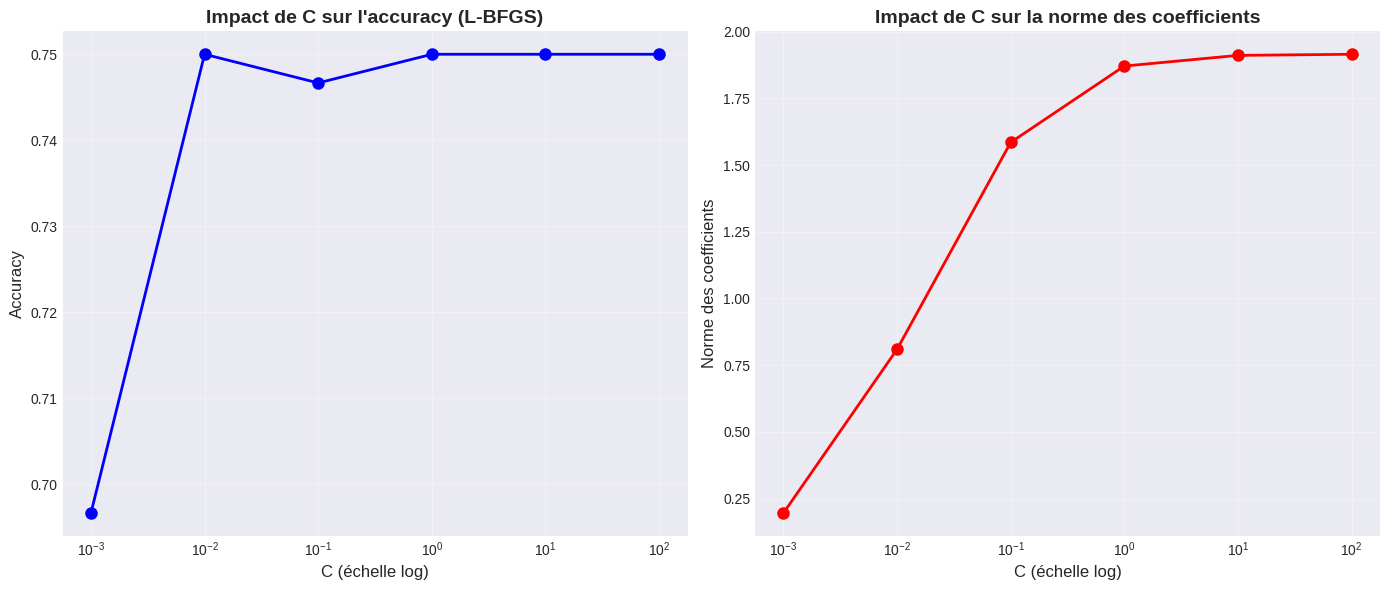

In [14]:
# %% [markdown]
# ## 10. Impact de la régularisation (paramètre C)

# %%
print("=" * 70)
print("IMPACT DU PARAMÈTRE DE RÉGULARISATION C")
print("=" * 70)

def analyze_regularization(solver='lbfgs', C_values=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]):
    """Analyse l'impact du paramètre C sur un solveur"""
    
    accuracies = []
    coef_norms = []
    valid_C_values = []  # Nouvelle liste pour stocker les C valides
    
    print(f"\nImpact de C pour {solver}:")
    for C in C_values:
        try:
            model = LogisticRegression(
                solver=solver,
                C=C,
                max_iter=1000,
                random_state=42,
                penalty='l2'
            )
            
            model.fit(X_synth_train, y_synth_train)
            
            y_pred = model.predict(X_synth_test)
            accuracy = accuracy_score(y_synth_test, y_pred)
            coef_norm = np.linalg.norm(model.coef_) if hasattr(model, 'coef_') else None
            
            accuracies.append(accuracy)
            coef_norms.append(coef_norm)
            valid_C_values.append(C)  # Ajouter seulement les C valides
            
            print(f"  C={C:.3f}: accuracy={accuracy:.4f}, "
                  f"||coef||={coef_norm:.4f if coef_norm else 'N/A'}")
            
        except Exception as e:
            print(f"  C={C:.3f}: Erreur - {str(e)}")
            # NE PAS ajouter NaN aux listes pour garder les dimensions cohérentes
            continue  # Passer au C suivant
    
    return valid_C_values, accuracies, coef_norms

# Analyse pour L-BFGS
C_vals, accs, norms = analyze_regularization(solver='lbfgs')

# Vérification des dimensions
print(f"\nDimensions vérifiées:")
print(f"C_vals: {len(C_vals)}, accs: {len(accs)}, norms: {len(norms)}")

# Visualisation seulement si on a des données valides
if len(C_vals) > 0 and len(accs) == len(C_vals):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.semilogx(C_vals, accs, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('C (échelle log)', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Impact de C sur l\'accuracy (L-BFGS)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Filtrer les normes valides (non-None)
    valid_norms = [(c, n) for c, n in zip(C_vals, norms) if n is not None]
    if valid_norms:
        C_norm, norm_vals = zip(*valid_norms)
        ax2.semilogx(C_norm, norm_vals, 'ro-', linewidth=2, markersize=8)
        ax2.set_xlabel('C (échelle log)', fontsize=12)
        ax2.set_ylabel('Norme des coefficients', fontsize=12)
        ax2.set_title('Impact de C sur la norme des coefficients', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Pas assez de données valides pour la visualisation")

In [16]:
# %% [markdown]
# ## 11. Test sur datasets réels

# %%
print("=" * 70)
print("TEST SUR DATASET RÉEL: BREAST CANCER")
print("=" * 70)

# Comparaison rapide sur le dataset Breast Cancer
results_cancer = {}

for solver in ['lbfgs', 'liblinear', 'saga']:
    print(f"\nTesting {solver} sur Breast Cancer...")
    
    results = evaluate_solver(
        X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test,
        solver=solver, penalty='l2', dataset_name="Breast Cancer"
    )
    
    if results:
        results_cancer[solver] = results
        print(f"  Accuracy: {results['accuracy']:.4f}")
        print(f"  Temps: {results['training_time']:.4f}s")

# %% [markdown]

TEST SUR DATASET RÉEL: BREAST CANCER

Testing lbfgs sur Breast Cancer...
✅ lbfgs évalué sur Breast Cancer
  Accuracy: 0.9883
  Temps: 1.4815s

Testing liblinear sur Breast Cancer...
✅ liblinear évalué sur Breast Cancer
  Accuracy: 0.9883
  Temps: 0.0058s

Testing saga sur Breast Cancer...
✅ saga évalué sur Breast Cancer
  Accuracy: 0.9883
  Temps: 0.1456s


In [17]:
# ## 12. Tableau récapitulatif

# %%
print("=" * 70)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("=" * 70)

# Création d'un DataFrame pour une vue d'ensemble
data = []
for solver, results in results_synth.items():
    if results:
        data.append({
            'Solver': solver.upper(),
            'Accuracy': f"{results['accuracy']:.4f}",
            'Time (s)': f"{results['training_time']:.4f}",
            'Iterations': results['n_iter'],
            'Converged': '✅' if results['converged'] else '❌',
            'Log Loss': f"{results.get('log_loss', 'N/A'):.4f}" if 'log_loss' in results else 'N/A'
        })

df_summary = pd.DataFrame(data)
print("\nPerformance sur le dataset synthétique:")
print(df_summary.to_string(index=False))

# %% [markdown]

TABLEAU RÉCAPITULATIF DES PERFORMANCES

Performance sur le dataset synthétique:
   Solver Accuracy Time (s)  Iterations Converged Log Loss
    LBFGS   0.7500   2.1300          12         ✅   0.4967
LIBLINEAR   0.7500   0.0055           5         ✅   0.4967
NEWTON-CG   0.7500   1.7332           5         ✅   0.4966
      SAG   0.7500   0.0630          34         ✅   0.4967
     SAGA   0.7500   0.0294          16         ✅   0.4967


In [18]:


# ## 13. Recommandations et conclusions

# %%
print("=" * 70)
print("RECOMMANDATIONS PRATIQUES")
print("=" * 70)

recommendations = """
📊 CONCLUSIONS ET RECOMMANDATIONS :

1. L-BFGS (Recommandé par défaut):
   - ✅ Bon compromis vitesse/précision
   - ✅ Supporte la multiclasse
   - ✅ Stable numériquement
   - ⚠️  Nécessite que les données soient standardisées

2. LIBLINEAR:
   - ✅ Très rapide sur petits datasets
   - ✅ Supporte L1 (sélection de features)
   - ❌ Uniquement binaire (one-vs-rest pour multiclasse)
   - ⚠️  Sensible au scaling des données

3. SAGA:
   - ✅ Excellent pour très grands datasets
   - ✅ Supporte L1, L2, ElasticNet
   - ✅ Bon pour la régularisation L1
   - ⚠️  Peut être plus lent sur petits datasets

4. NEWTON-CG:
   - ✅ Précis avec peu d'itérations
   - ✅ Supporte la multiclasse
   - ⚠️  Coûteux en mémoire pour nombreuses features

5. SAG:
   - ✅ Efficace sur grands datasets
   - ⚠️  Ne supporte pas L1
   - ⚠️  Moins stable que SAGA

📍 RECOMMANDATION GÉNÉRALE:
   - Par défaut: utiliser L-BFGS
   - Pour la sélection de variables: LIBLINEAR ou SAGA avec L1
   - Pour très grands datasets: SAG ou SAGA
   - Toujours standardiser les données avant
   - Ajuster max_iter selon la complexité du problème
"""

print(recommendations)

# %% [markdown]

RECOMMANDATIONS PRATIQUES

📊 CONCLUSIONS ET RECOMMANDATIONS :

1. L-BFGS (Recommandé par défaut):
   - ✅ Bon compromis vitesse/précision
   - ✅ Supporte la multiclasse
   - ✅ Stable numériquement
   - ⚠️  Nécessite que les données soient standardisées

2. LIBLINEAR:
   - ✅ Très rapide sur petits datasets
   - ✅ Supporte L1 (sélection de features)
   - ❌ Uniquement binaire (one-vs-rest pour multiclasse)
   - ⚠️  Sensible au scaling des données

3. SAGA:
   - ✅ Excellent pour très grands datasets
   - ✅ Supporte L1, L2, ElasticNet
   - ✅ Bon pour la régularisation L1
   - ⚠️  Peut être plus lent sur petits datasets

4. NEWTON-CG:
   - ✅ Précis avec peu d'itérations
   - ✅ Supporte la multiclasse
   - ⚠️  Coûteux en mémoire pour nombreuses features

5. SAG:
   - ✅ Efficace sur grands datasets
   - ⚠️  Ne supporte pas L1
   - ⚠️  Moins stable que SAGA

📍 RECOMMANDATION GÉNÉRALE:
   - Par défaut: utiliser L-BFGS
   - Pour la sélection de variables: LIBLINEAR ou SAGA avec L1
   - Pour très g

In [21]:


# ## 14. Code pour tester votre propre solveur

# %%
# %% [markdown]
# ### Test personnalisé avec votre propre configuration

# %%
def test_custom_solver(solver_name='lbfgs', penalty='l2', C=1.0, max_iter=1000):
    """
    Fonction pour tester rapidement un solveur avec vos paramètres
    """
    print(f"Test du solveur: {solver_name}")
    print(f"Paramètres: penalty={penalty}, C={C}, max_iter={max_iter}")
    print("-" * 50)
    
    model = LogisticRegression(
        solver=solver_name,
        penalty=penalty,
        C=C,
        max_iter=max_iter,
        random_state=42
    )
    
    # Mesure du temps
    start_time = time.time()
    model.fit(X_synth_train, y_synth_train)
    training_time = time.time() - start_time
    
    # Prédictions
    y_pred = model.predict(X_synth_test)
    y_pred_proba = model.predict_proba(X_synth_test)[:, 1]
    
    # Métriques
    accuracy = accuracy_score(y_synth_test, y_pred)
    logloss = log_loss(y_synth_test, y_pred_proba)
    
    print(f"Résultats:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Log Loss: {logloss:.4f}")
    print(f"  Temps d'entraînement: {training_time:.4f}s")
    print(f"  Nombre d'itérations: {model.n_iter_[0]}")
    print(f"  Convergé: {'Oui' if model.n_iter_[0] < max_iter else 'Non'}")
    
    return model, accuracy, training_time

# Exemple d'utilisation
model, acc, time_taken = test_custom_solver(solver_name='lbfgs', C=0.5, max_iter=500)

Test du solveur: lbfgs
Paramètres: penalty=l2, C=0.5, max_iter=500
--------------------------------------------------
Résultats:
  Accuracy: 0.7467
  Log Loss: 0.4963
  Temps d'entraînement: 0.0150s
  Nombre d'itérations: 12
  Convergé: Oui
